# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-4               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 2
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean #+ rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

## Visualize data

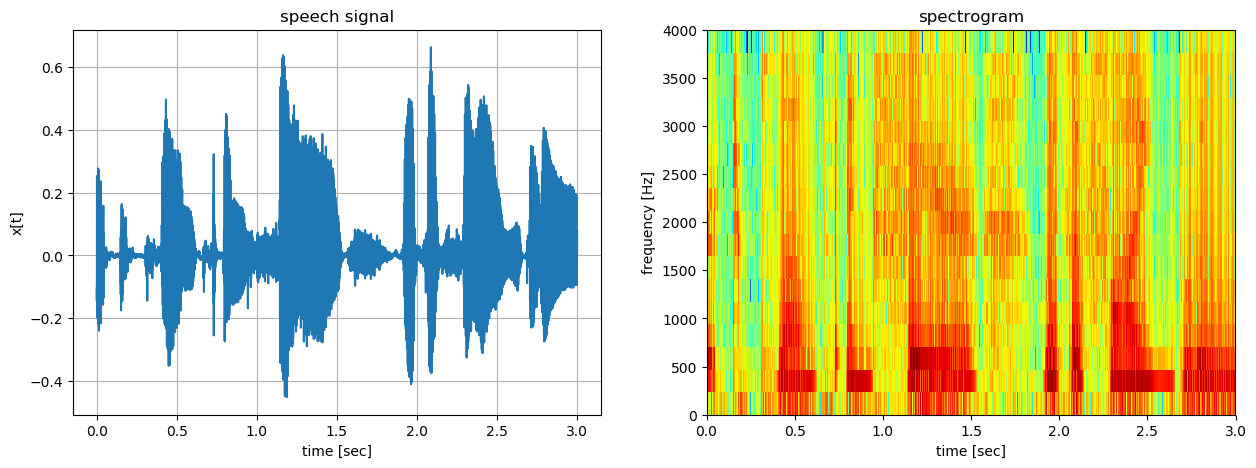

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
Œ≥ = Array{Variable,1}(undef, 2*length(freq))
Œ∏ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Œ£_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:Œ≥,k)] Œ≥[k] ~ ForneyLab.Gamma(placeholder(pad(:a_Œ≥,k)), placeholder(pad(:b_Œ≥,k)))
    @RV [id=pad(:Œ∏,k)] Œ∏[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_Œ∏,k), dims=(AR_order,)), placeholder(pad(:Œ£_Œ∏,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(Œ∏[k], z_min[k], Œ≥[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3764977361209358550 -->
 3764977361209358550 
 
 placeholder_Œº_Œ∏_20 
 
<!-- 10534868716565119180 -->
 10534868716565119180 
 
 placeholder_Œº_Œ∏_04 
 
<!-- 462992743705820791 -->
 462992743705820791 
 
 Gam 
 gamma_5 
 
<!-- 4714381890330588669 -->
 4714381890330588669 
 
 placeholder_a_Œ≥_05 
 
<!-- 462992743705820791--4714381890330588669 -->
 462992743705820791--4714381890330588669 
 
 a_Œ≥_05 
 1 out 
 2 a 
 
<!-- 8590899447281007132 -->
 8590899447281007132 
 
 placeholder_b_Œ≥_05 
 
<!-- 462992743705820791--8590899447281007132 -->
 462992743705820791--8590899447281007132 
 
 b_Œ≥_05 
 1 out 
 3 b 
 
<!-- 4289382193277640007 -->
 4289382193277640007 
 
 AR 
 autoregressive_17 
 
<!-- 11141670496937011410 -->
 11141670496937011410 
 
 Gam 
 gamma_17 
 
<!-- 4289382193277640007--11141670496937011410 -->
 4289382193277640007--11141670496937011410 
 
 Œ≥_17 
 1 out 
 4 Œ≥ 
 
<!-- 8040441217127653192 -->
 8040441217127653192 
 
 ùí© 
 gaussianmeanvariance_34 
 
<!-- 4289382193277640007--8040441217127653192 -->
 4289382193277640007--8040441217127653192 
 
 z_min_17 
 1 out 
 2 x 
 
<!-- 7560049867875704230 -->
 7560049867875704230 
 
 ùí© 
 gaussianmeanvariance_35 
 
<!-- 4289382193277640007--7560049867875704230 -->
 4289382193277640007--7560049867875704230 
 
 Œ∏_17 
 1 out 
 3 Œ∏ 
 
<!-- 5653687027313223980 -->
 5653687027313223980 
 
 ùí© 
 gaussianmeanvariance_13 
 
<!-- 10782664462526437694 -->
 10782664462526437694 
 
 placeholder_Œ£_Œ∏_06 
 
<!-- 5653687027313223980--10782664462526437694 -->
 5653687027313223980--10782664462526437694 
 
 Œ£_Œ∏_06 
 1 out 
 3 v 
 
<!-- 9665825432919750134 -->
 9665825432919750134 
 
 placeholder_Œº_Œ∏_06 
 
<!-- 5653687027313223980--9665825432919750134 -->
 5653687027313223980--9665825432919750134 
 
 Œº_Œ∏_06 
 1 out 
 2 m 
 
<!-- 16529289711784780856 -->
 16529289711784780856 
 
 placeholder_a_Œ≥_26 
 
<!-- 15431699312566321362 -->
 15431699312566321362 
 
 placeholder_Œº_Œ∏_03 
 
<!-- 8801915816311097242 -->
 8801915816311097242 
 
 placeholder_b_Œ≥_13 
 
<!-- 12605488694496054280 -->
 12605488694496054280 
 
 placeholder_b_Œ≥_22 
 
<!-- 18000630877674015757 -->
 18000630877674015757 
 
 Gam 
 gamma_28 
 
<!-- 753053536141552825 -->
 753053536141552825 
 
 placeholder_a_Œ≥_28 
 
<!-- 18000630877674015757--753053536141552825 -->
 18000630877674015757--753053536141552825 
 
 a_Œ≥_28 
 1 out 
 2 a 
 
<!-- 4104683442398584893 -->
 4104683442398584893 
 
 placeholder_b_Œ≥_28 
 
<!-- 18000630877674015757--4104683442398584893 -->
 18000630877674015757--4104683442398584893 
 
 b_Œ≥_28 
 1 out 
 3 b 
 
<!-- 12611759170658119934 -->
 12611759170658119934 
 
 placeholder_a_Œ≥_19 
 
<!-- 12939027840574001724 -->
 12939027840574001724 
 
 ùí© 
 gaussianmeanvariance_21 
 
<!-- 14470415831612982927 -->
 14470415831612982927 
 
 placeholder_Œ£_Œ∏_10 
 
<!-- 12939027840574001724--14470415831612982927 -->
 12939027840574001724--14470415831612982927 
 
 Œ£_Œ∏_10 
 1 out 
 3 v 
 
<!-- 14346282785550433817 -->
 14346282785550433817 
 
 placeholder_Œº_Œ∏_10 
 
<!-- 12939027840574001724--14346282785550433817 -->
 12939027840574001724--14346282785550433817 
 
 Œº_Œ∏_10 
 1 out 
 2 m 
 
<!-- 18074274755518351508 -->
 18074274755518351508 
 
 placeholder_Œº_z_min_17 
 
<!-- 4235549605740198551 -->
 4235549605740198551 
 
 Gam 
 gamma_24 
 
<!-- 6754460123876608781 -->
 6754460123876608781 
 
 placeholder_a_Œ≥_24 
 
<!-- 4235549605740198551--6754460123876608781 -->
 4235549605740198551--6754460123876608781 
 
 a_Œ≥_24 
 1 out 

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏, z, z_min, Œ≥, ids=[:Œ∏ :z :z_min :Œ≥])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepŒ≥!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:Œ∏_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:Œ∏_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_Œ≥_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_Œ≥_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:Œ∏_28], noth

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
Œº_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_Œ≥_min = Array{Float64,1}(undef, 2*length(freq))
b_Œ≥_min = Array{Float64,1}(undef, 2*length(freq))
Œº_Œ∏_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_Œ∏_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    Œº_z_min[k] = randn(AR_order)
    Œ£_z_min[k] = 1e10*Ic(AR_order)
    a_Œ≥_min[k] = 1000000
    b_Œ≥_min[k] = 100
    Œº_Œ∏_min[k] = randn(AR_order)
    Œ£_Œ∏_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:Œ≥, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_Œ≥_min[k], b=b_Œ≥_min[k])
    marginals[pad(:Œ∏, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_Œ∏_min[k], v=Œ£_Œ∏_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_z_min[k], v=Œ£_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
Œº_x = Array{Float64,1}[]
Œ£_x = Array{Float64,2}[]
Œº_s = Array{Float64,1}[]
Œ£_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_Œ≥, f)] = a_Œ≥_min[f]
        data[pad(:b_Œ≥, f)] = b_Œ≥_min[f]
        data[pad(:Œº_Œ∏, f)] = Œº_Œ∏_min[f]
        data[pad(:Œ£_Œ∏, f)] = Œ£_Œ∏_min[f]
        data[pad(:Œº_z_min, f)] = Œº_z_min[f]
        data[pad(:Œ£_z_min, f)] = Œ£_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(Œº_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Œ£_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        #marginals = Base.invokelatest(stepŒ≥!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ∏!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(Œº_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Œ£_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        Œº_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Œ£_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        #a_Œ≥_min[f] = marginals[pad(:Œ≥,f)].params[:a]
        #b_Œ≥_min[f] = marginals[pad(:Œ≥,f)].params[:b]
        Œº_Œ∏_min[f] = ForneyLab.unsafeMean(marginals[pad(:Œ∏,f)])
        Œ£_Œ∏_min[f] = ForneyLab.unsafeCov(marginals[pad(:Œ∏,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:19:029:21


In [9]:
ForneyLab.unsafeCov(marginals[:Œ∏_01])

2√ó2 Array{Float64,2}:
  3.57643e-5  -3.57643e-5
 -3.57643e-5   3.57658e-5

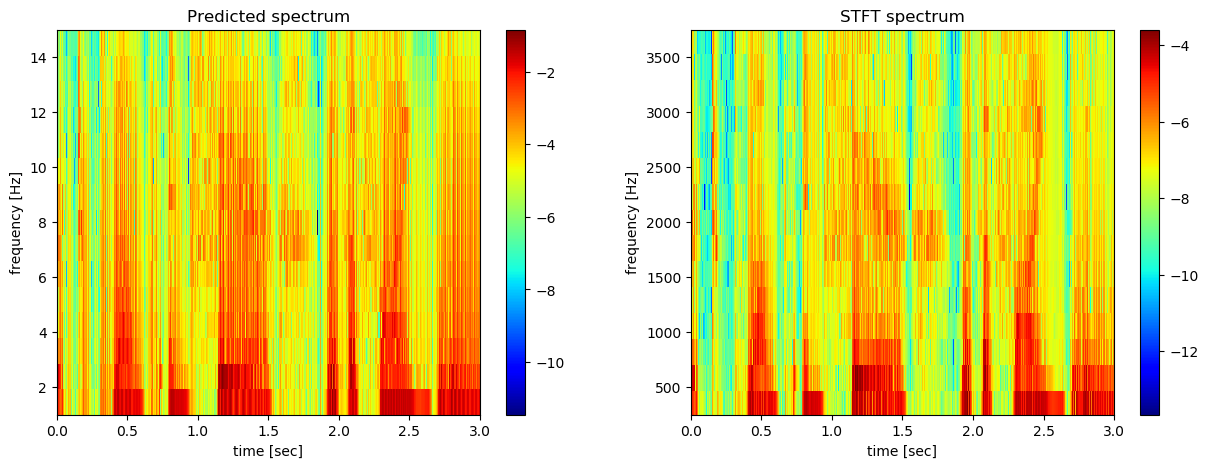

In [10]:
# convert ŒºŒ∏a 1d array
#Œº_x_pred = expand((hcat(Œº_x...),dims=1))

# convert s_x to a 2d array
if length(size(Œº_s)) != 2
    Œº_s = hcat(Œº_s...)
end

# calculate magnitude spectrum
mag_Œº_s = log10.((Œº_s[1:length(freq),:].^2 + Œº_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_Œº_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

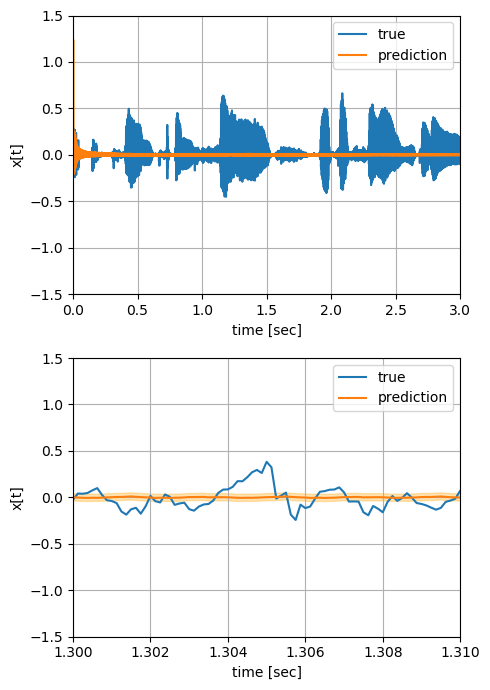

In [11]:
# create figure with subplots
fig, ax = plt.subplots(nrows=2, figsize=(5,7))

Œº_x_pred_select = [Œº_x[k][1] for k = 1:length(Œº_x)]
var_x_pred_select = [Œ£_x[k][1,1] for k = 1:length(Œº_x)]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[buffer_size:length(Œº_x_pred_select)+buffer_size-1], Œº_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[buffer_size:length(Œº_x_pred_select)+buffer_size-1], Œº_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[buffer_size:length(Œº_x_pred_select)+buffer_size-1], Œº_x_pred_select .- sqrt.(var_x_pred_select), Œº_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.3,1.31), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()
plt.tight_layout()

#plt.savefig("figures/all_AR02.png", dpi=500)

# create audioplayers
audioplayers(x_time, x_time_clean, Œº_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [12]:
MSE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[buffer_size:length(Œº_x_pred_select)+buffer_size-1]).^2)

0.010603182701747085

In [13]:
MAE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[buffer_size:length(Œº_x_pred_select)+buffer_size-1]))

0.06404412427916852

In [14]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(Œº_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(Œº_x_pred_select[k], sqrt(var_x_pred_select[k])), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 23970       mean:-1.202175492684144